<head>
<link rel="stylesheet" href="../../../cssthemes/github.css">
<meta name="viewport" content="initial-scale=1, width=device-width">
</head>

In [237]:
import sys
print(sys.executable)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
InteractiveShell.colors = "Linux"
InteractiveShell.separate_in = 0
from random import randint
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import style
style.use('fivethirtyeight')
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import seaborn as sns
from plotnine import ggplot, geom_histogram, aes

/home/jcmint/anaconda3/envs/learningenv/bin/python


# Linear and Decision Tree Regression
Linear model and decision tree regression seem pretty straightforward.
Here I want to see if the RMSE is decreased for a regression model based on 1960 through 2014 data that is predicting `Population, total` as a function of all other variables. I would need to filter by year, drop all but three columns (country, indicator type and value) and pivot the table on the country name to get a wide data set. This can be fed directly into the linear regression model.
Then, iterate through random training and testing data split to get a distribution of RMSE values. Graph the RMSE of as the prediction error vs year on the x axis.
This exercise was somewhat contrived, and I ended up using a simple time series manipulation of the data for demonstration purposes.

In [66]:
indicators = pd.read_csv('../../../../data/w5vis/Indicators.csv')

In [67]:
indicators.head()

,CountryName,CountryCode,IndicatorName,IndicatorCode,Year,Value
0,Arab World,ARB,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,1960,1.335609e+02
1,Arab World,ARB,Age dependency ratio (% of working-age populat...,SP.POP.DPND,1960,8.779760e+01
2,Arab World,ARB,"Age dependency ratio, old (% of working-age po...",SP.POP.DPND.OL,1960,6.634579e+00
3,Arab World,ARB,"Age dependency ratio, young (% of working-age ...",SP.POP.DPND.YG,1960,8.102333e+01
4,Arab World,ARB,Arms exports (SIPRI trend indicator values),MS.MIL.XPRT.KD,1960,3.000000e+06


,CountryName,IndicatorName,Value
4839015,Arab World,Access to electricity (% of population),84.342225
4839016,Arab World,"Access to electricity, rural (% of rural popul...",71.969903
4839017,Arab World,"Access to electricity, urban (% of urban popul...",93.828463
4839018,Arab World,Access to non-solid fuel (% of population),86.003666
4839019,Arab World,"Access to non-solid fuel, rural (% of rural po...",74.552598


In [114]:
%%capture
# preallocate dataframe
output = pd.DataFrame(columns = ['Year', 'Amount of Data', 'RMSE Average', 'R Squared Average'], index = range(0, 2015 - 1960))
j = 0;
# Calculate RMSE for each regression model based on year
for i in range(1960, 2015, 1):
test = indicators.copy()
test = test[test['Year'] == i]
del test['CountryCode']
del test['IndicatorCode']
del test['Year']
wide = test.pivot(index='CountryName', columns='IndicatorName', values='Value')
wide = wide[~wide['Population, total'].isna()]# drop any rows missing the target variable - this ensures that I won't drop the column by accident later..
wide = wide.dropna(axis = 1, thresh = 0.85*len(wide))
wide = wide.dropna(axis = 0, how = "any")
#print("Year: ", i, "; Remaining rows and columns", wide.shape, "; Total amount of data: ", wide.shape[0] * wide.shape[1], "; Any Missing data? ", wide.isnull().values.any())
x = wide.loc[:, wide.columns != 'Population, total']
y = wide['Population, total']
RMSE = [None] * 10
r2 = [None] * 10
for k in range(0, 10, 1):
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=randint(0,1000000));
regressor = LinearRegression();
regressor.fit(x_train, y_train);
y_prediction = regressor.predict(x_test);
RMSE[k] = sqrt(mean_squared_error(y_true = y_test, y_pred = y_prediction));
r2[k] = r2_score(y_true = y_test, y_pred = y_prediction)
output.iloc[j, 0] = i
output.iloc[j, 1] = wide.shape[0] * wide.shape[1]
output.iloc[j, 2] = sum(RMSE)/len(RMSE)
output.iloc[j, 3] = sum(r2)/len(r2)
j+=1

I tested the processing of data by year to get rid of NA values. When iterating through the available years I want to

In [186]:
output.head()

,Year,Amount of Data,RMSE Average,R Squared Average
0,1960,2254,9.11015e+07,0.036731
1,1961,2688,1.01918e+08,0.877477
2,1962,3330,1.35075e+08,0.853944
3,1963,3162,4.26152e+08,-2.74594
4,1964,3162,4.32376e+08,-2.71138


After being stumped for a while, I realized what I was doing wrong. This was a somewhat silly example because there are many columns which may be 100% colinear with the `Population, total` column.

In [130]:
test = indicators.copy()
test = test[test['Year'] == i]
del test['CountryCode']
del test['IndicatorCode']
del test['Year']
wide = test.pivot(index='CountryName', columns='IndicatorName', values='Value')
wide.columns[wide.columns.str.contains("pop")][0:10]
len(wide.columns[wide.columns.str.contains("pop")])

Index(['Adult literacy rate, population 15+ years, both sexes (%)',
       'Adult literacy rate, population 15+ years, female (%)',
       'Adult literacy rate, population 15+ years, male (%)',
       'Age dependency ratio (% of working-age population)',
       'Age dependency ratio, old (% of working-age population)',
       'Age dependency ratio, young (% of working-age population)',
       'Annualized average growth rate in per capita real survey mean consumption or income, bottom 40% of population (%)',
       'Annualized average growth rate in per capita real survey mean consumption or income, total population (%)',
       'Condom use, population ages 15-24, female (% of females ages 15-24)',
       'Condom use, population ages 15-24, male (% of males ages 15-24)'],
      dtype='object', name='IndicatorName')

63

Therefore, I need to drop these rows to make my example actually 'predict' values.

In [183]:
%%capture
# preallocate dataframe
output = pd.DataFrame(columns = ['Year', 'Amount of Data', 'RMSE Average', 'R Squared Average'], index = range(0, 2015 - 1960))
j = 0;
# Calculate RMSE for each regression model based on year
for i in range(1960, 2015, 1):
test = indicators.copy()
test = test[test['Year'] == i]
del test['CountryCode']
del test['IndicatorCode']
del test['Year']
wide = test.pivot(index='CountryName', columns='IndicatorName', values='Value')
wide = wide[~wide['Population, total'].isna()]# drop any rows missing the target variable - this ensures that I won't drop the column by accident later..
wide = wide.dropna(axis = 1, thresh = 0.85*len(wide))
wide = wide.dropna(axis = 0, how = "any")
#print("Year: ", i, "; Remaining rows and columns", wide.shape, "; Total amount of data: ", wide.shape[0] * wide.shape[1], "; Any Missing data? ", wide.isnull().values.any())
y = wide['Population, total']
# Drop potentially colinear variables (my guess)
wide = wide[wide.columns.drop(list(wide.filter(regex='pop')))]
wide = wide[wide.columns.drop(list(wide.filter(regex='Pop')))]
x = wide.loc[:, wide.columns != 'Population, total']
RMSE = [None] * 10
r2 = [None] * 10
for k in range(0, 10, 1):
x_train, x_test, y_train, y_test = train_test_split(wide, y, test_size=0.33, random_state=324);
regressor = LinearRegression();
regressor.fit(x_train, y_train);
y_prediction = regressor.predict(x_test);
RMSE[k] = sqrt(mean_squared_error(y_true = y_test, y_pred = y_prediction));
r2[k] = r2_score(y_true = y_test, y_pred = y_prediction)
output.iloc[j, 0] = i
output.iloc[j, 1] = wide.shape[0] * wide.shape[1]
output.iloc[j, 2] = sum(RMSE)/len(RMSE)
output.iloc[j, 3] = sum(r2)/len(r2)
j+=1

Trying to get this example to work may be too contrived without manual PCA or feature selection, so I decided to just try another approach - generate a linear regression model for each country as a function of year.

In [218]:
%%capture
countries = indicators['CountryName'].unique().tolist()
output = pd.DataFrame(columns = ['Country', 'RMSE Average', 'R Squared Average'], index = range(0, len(countries) + 1))
k = 0
for i in countries:
wide = indicators.copy()
del wide['CountryCode']
del wide['IndicatorCode']
cond_1 = wide['CountryName'] == i
cond_2 = wide['IndicatorName'] == 'Population, total'
wide = wide[cond_1 & cond_2]
del wide['IndicatorName']
RMSE = [None] * 10
r2 = [None] * 10
for j in range(0, 10, 1):
x_train, x_test, y_train, y_test = train_test_split(pd.DataFrame(wide['Year']), pd.DataFrame(wide['Value']), test_size=0.33, random_state=randint(0,1000000))
regressor = LinearRegression();
regressor.fit(x_train, y_train);
y_prediction = regressor.predict(x_test);
RMSE[j] = sqrt(mean_squared_error(y_true = y_test, y_pred = y_prediction));
r2[j] = r2_score(y_true = y_test, y_pred = y_prediction)
output.iloc[k, 0] = i
output.iloc[k, 1] = sum(RMSE)/len(RMSE)
output.iloc[k, 2] = sum(r2)/len(r2)
k+=1

In [261]:
output.head()
output = output.dropna()
output.sort_values('R Squared Average').head()
from scipy.stats import describe
describe(output['R Squared Average'])

,Country,RMSE Average,R Squared Average
0,Arab World,1.19366e+07,0.981009
1,Caribbean small states,80474.8,0.990475
2,Central Europe and the Baltics,4.43389e+06,0.236114
3,East Asia & Pacific (all income levels),3.7243e+07,0.989137
4,East Asia & Pacific (developing only),3.27897e+07,0.991255


,Country,RMSE Average,R Squared Average
201,Sint Maarten (Dutch part),2924.69,-0.297575
210,St. Kitts and Nevis,4084.1,-0.19532
80,Croatia,163570,-0.150368
145,Lithuania,272980,-0.14565
94,Estonia,92947.5,-0.117783


DescribeResult(nobs=247, minmax=(-0.29757490589067603, 0.9996578791364774), mean=0.8691825934749658, variance=0.06901810751504184, skewness=-2.9841692292997424, kurtosis=8.029106379317444)

Running the code ended up taking about 10 minutes for 2460 linear regression models. I also graph the pop for a random country with a negative r2 value.

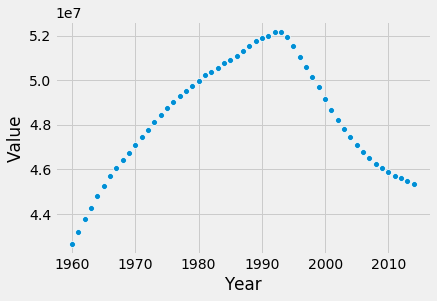

In [224]:
wide = indicators.copy()
del wide['CountryCode']
del wide['IndicatorCode']
cond_1 = wide['CountryName'] == 'Ukraine'
cond_2 = wide['IndicatorName'] == 'Population, total'
wide = wide[cond_1 & cond_2]
del wide['IndicatorName']
sns.scatterplot(x = 'Year', y='Value', data  = wide)